# Is it a bird?

In [3]:
import socket,warnings
try:
    # 检测是否有网络
    socket.setdefaulttimeout(1)
    # 用一个不存在的域名来检测网络连接
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex:
    raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [5]:
# 安装fastai和duckduckgo_search
!pip install -Uqq fastai duckduckgo_search

2015年，创建一个可以识别鸟类的计算机系统的想法被认为极具挑战性，这就是XKCD笑话的基础：
![image](https://imgs.xkcd.com/comics/tasks.png)
但今天，我们可以使用完全免费的资源，在短短几分钟内做到这一点！
我们将采取的基本步骤是：
1. 使用DuckDuckGo搜索“鸟类照片”的图像
2. 使用DuckDuckGo搜索“森林照片”的图像
3. 微调预训练的神经网络来识别这两组
4. 试着在一张鸟的照片上运行这个模型，看看它是否有效。
## 步骤1：下载鸟类和非鸟类的图像

In [8]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

让我们从搜索一张鸟的照片开始，看看我们得到了什么样的结果。我们将从搜索中获取URL开始：

In [12]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = ['https://www.almanac.com/sites/default/files/image_nodes/bluebird-3456115_1920.jpg']
urls

['https://www.almanac.com/sites/default/files/image_nodes/bluebird-3456115_1920.jpg']


['https://www.almanac.com/sites/default/files/image_nodes/bluebird-3456115_1920.jpg']

…然后下载一个URL并查看它：

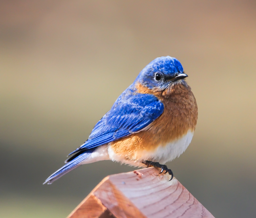

In [13]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

现在让我们对“森林照片”做同样的处理：

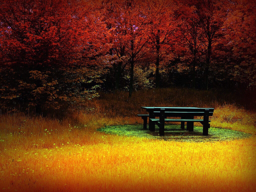

In [15]:
image_file = download_url(url='https://www.wallpapergeeks.com/wp-content/uploads/2015/10/autumn-bliss-wallpaper-1.jpg')
Image.open(image_file).to_thumb(256,256)

我们的搜索似乎给出了合理的结果，所以让我们举几个“鸟”和“森林”照片的例子，并将每组照片保存到不同的文件夹中（我也试图在这里获取一系列照明条件）：

In [16]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10) 
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


## Step 2: 训练我们的模型
有些照片可能无法正确下载，这可能会导致我们的模型训练失败，因此我们将删除它们：

In [17]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

为了训练模型，我们需要DataLoaders，它是一个包含训练集（用于创建模型的图像）和验证集（用于检查模型准确性的图像，在训练期间不使用）的对象。在fastai中，我们可以使用DataBlock轻松创建它，并从中查看示例图像：

In [18]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]  
).dataloaders(path, bs=32)
dls.show_batch(max_n=6)

TypeError: 'NoneType' object is not iterable